In [1]:
from lsdt_fluidsim import*

from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import math
from scipy.interpolate import interp1d
  
#########################################################################
##### Beschreibung Programm #############################################
#########################################################################

""" 
Das Programm dient der Berechnung des Systemverhaltens von hydraulischen Systemen

Sofern nicht anderes bezeichnet werden für alle Variablen SI-Einheiten verwendet!

Bemerkungen:
- Die numerische Berechnung erfolgt mittels Runge Kutta Verfahren (RK4)
- Die Genauigkeit der Ergebnisse hängen von der Zeitschrittweite und der Simulationsdauer ab
- Eine zu kein gewählte Schrittweite führt in der Regel zu einer Energiezufuhr ins System
- Je höher die Steifigkeit des Systems, desto kleiner muss die Simulationsschrittweite gewählt werden
"""
#########################################################################
##### Allgemeine Einstellungen ##########################################
#########################################################################

Bilder_speichern                     = True
CSV_speichern                        = True
Berechnung_Massestrombasiert         = True

#########################################################################
##### Messung einlesen (optional) #######################################
#########################################################################

#########################################################################
##### Simulationsparameter ##############################################
#########################################################################

Input_t_start                        = 0             # Simulationszeit Start [s]
Input_t_ende                         = 0.3           # Simulationszeit Ende [s]
Input_delta_t                        = 0.0001        # Zeitschrittweite [s]

Input_E1_alpha                       = 0.6           # Alpha der Blende [-]
Input_E1_d                           = 0.001         # Durchmesser der Blende [m]
Input_E2_alpha                       = 0.6           # Alpha der Blende [-]
Input_E2_d                           = 0.0005        # Durchmesser der Blende [m]
Input_E4_d                           = 0.01          # Durchmesser des Rohres [m]
Input_E4_l                           = 0.1           # Länge des Rohres [m]
Input_E5_d                           = 0.01          # Durchmesser des Rohres [m]
Input_E5_l                           = 0.1           # Länge des Rohres [m]

Input_Fluid_rho0                     = 8700          # Dichte bei Atmosphaerendruck [kg/m^3]
Input_Fluid_E                        = 1.4e9         # Elastizitätsmodul [Pa]
PARAMETER_FLUID = [Input_Fluid_rho0,
                   Input_Fluid_E]

#########################################################################
##### Anfangsvolumen der Knoten #########################################
#########################################################################

K1.V   = 0.003
K2.V   = 0.001
K3.V   = 0.001

K11.V  = 0.003
K12.V  = 0.001
K13.V  = 0.001

K21.V  = 0.003
K22.V  = 0.001
K23.V  = 0.001

#########################################################################
##### Anfangsrandbedingungen der Knoten #################################
#########################################################################

K1.p   = 1.0e5
K2.p   = 0.0
K3.p   = 0.0

K11.p  = 1.0e5
K12.p  = 0.0
K13.p  = 0.0

K21.p  = 1.0e5
K22.p  = 0.0
K23.p  = 0.0

#########################################################################
##### Erstellung aller Elemente E und Knotenelemente EK #################
#########################################################################
"""
Modell Volumenstrombasiert:
    EK1:  Kapazität
    E1:   Blende       & E4:   Rohrleitung_Induktivität    
    EK2:  Kapazität
    E2:   Blende       & E5:   Rohrleitung_Induktivität        
    EK3:  Kapazität
    
Modell Massenstrombasiert:
    EK11:  Kapazität
    E11:   Blende      & E14:  Rohrleitung_Induktivität       
    EK12:  Kapazität
    E12:   Blende      & E15:  Rohrleitung_Induktivität       
    EK13:  Kapazität
        
Modell Massenstrombasiert:
    EK21:  Kapazität
    E21:   Blende
    EK22:  Kapazität
    E22:   Blende
    EK23:  Kapazität
        
"""

EK1                              = class_DGL_Behaelter_starr_Volumenstrombasiert(PARAMETER_FLUID,[K1])
E1                               = class_Blende_R(PARAMETER_FLUID,Input_E1_alpha,Input_E1_d,[K1, K2])
E4                               = class_Rohrleitung_L(PARAMETER_FLUID,Input_E4_l,Input_E4_d,[K1, K2])
EK2                              = class_DGL_Behaelter_starr_Volumenstrombasiert(PARAMETER_FLUID,[K2])
E2                               = class_Blende_R(PARAMETER_FLUID,Input_E2_alpha,Input_E2_d,[K2, K3])
E5                               = class_Rohrleitung_L(PARAMETER_FLUID,Input_E5_l,Input_E5_d,[K2, K3])
EK3                              = class_DGL_Behaelter_starr_Volumenstrombasiert(PARAMETER_FLUID,[K3])

EK11                             = class_DGL_Behaelter_starr_Massenstrombasiert(PARAMETER_FLUID,[K11])
E11                              = class_Blende_R(PARAMETER_FLUID,Input_E1_alpha,Input_E1_d,[K11, K12])
E14                              = class_Rohrleitung_L(PARAMETER_FLUID,Input_E4_l,Input_E4_d,[K11, K12])
EK12                             = class_DGL_Behaelter_starr_Massenstrombasiert(PARAMETER_FLUID,[K12])
E12                              = class_Blende_R(PARAMETER_FLUID,Input_E2_alpha,Input_E2_d,[K12, K13])
E15                              = class_Rohrleitung_L(PARAMETER_FLUID,Input_E5_l,Input_E5_d,[K12, K13])
EK13                             = class_DGL_Behaelter_starr_Massenstrombasiert(PARAMETER_FLUID,[K13])

EK21                             = class_DGL_Behaelter_starr_Massenstrombasiert(PARAMETER_FLUID,[K21])
E21                              = class_Blende_R(PARAMETER_FLUID,Input_E1_alpha,Input_E1_d,[K21, K22])
EK22                             = class_DGL_Behaelter_starr_Massenstrombasiert(PARAMETER_FLUID,[K22])
E22                              = class_Blende_R(PARAMETER_FLUID,Input_E2_alpha,Input_E2_d,[K22, K23])
EK23                             = class_DGL_Behaelter_starr_Massenstrombasiert(PARAMETER_FLUID,[K23])

#########################################################################
##### Start der Simulation ##############################################
#########################################################################

t = Input_t_start
while (t < Input_t_ende):
    #Erst einmal alle Volumenströme und Massenströme zu Null setzen, da diese an den Knoten aufsummiert werden
    Reset_Knotenstroeme()            
                                        
    #Berechnung der Volumenströme an den sekundären Elementen (für volumenstrombasierte )
    E1.Berechnung_Volumenstroeme(Input_delta_t)        
    E2.Berechnung_Volumenstroeme(Input_delta_t)   
    E4.Berechnung_Volumenstroeme(Input_delta_t)   
        
    E11.Berechnung_Massenstroeme(Input_delta_t)    
    E12.Berechnung_Massenstroeme(Input_delta_t)    
    E14.Berechnung_Massenstroeme(Input_delta_t)    
    
    E21.Berechnung_Massenstroeme(Input_delta_t)    
    E22.Berechnung_Massenstroeme(Input_delta_t)    
    
    #Berechnung des Druckaufbaus an den Knoten
    EK1.Loesung_Differentialgleichung_Zeitschritt(Input_delta_t)                  
    EK2.Loesung_Differentialgleichung_Zeitschritt(Input_delta_t)                  
    EK3.Loesung_Differentialgleichung_Zeitschritt(Input_delta_t)                  
    
    EK11.Loesung_Differentialgleichung_Zeitschritt(Input_delta_t)                  
    EK12.Loesung_Differentialgleichung_Zeitschritt(Input_delta_t)                  
    EK13.Loesung_Differentialgleichung_Zeitschritt(Input_delta_t)                  
    
    EK21.Loesung_Differentialgleichung_Zeitschritt(Input_delta_t)                  
    EK22.Loesung_Differentialgleichung_Zeitschritt(Input_delta_t)                  
    EK23.Loesung_Differentialgleichung_Zeitschritt(Input_delta_t)                  
                   
    #Datenlogger Knoten
    Datenlogger_Knoten_schreiben(t)
                         
    #Datenlogger Elemente    
    datenlogger_E1.Werte_anhaengen(E1)
    datenlogger_E2.Werte_anhaengen(E2)        
    
    datenlogger_E11.Werte_anhaengen(E11)
    datenlogger_E12.Werte_anhaengen(E12)        
    
    datenlogger_E21.Werte_anhaengen(E21)
    datenlogger_E22.Werte_anhaengen(E22)        
    
    t = t + Input_delta_t

if (CSV_speichern == True):
    csv_schreiben('../output_csv/druck_k1.csv',datenlogger_K2)
    

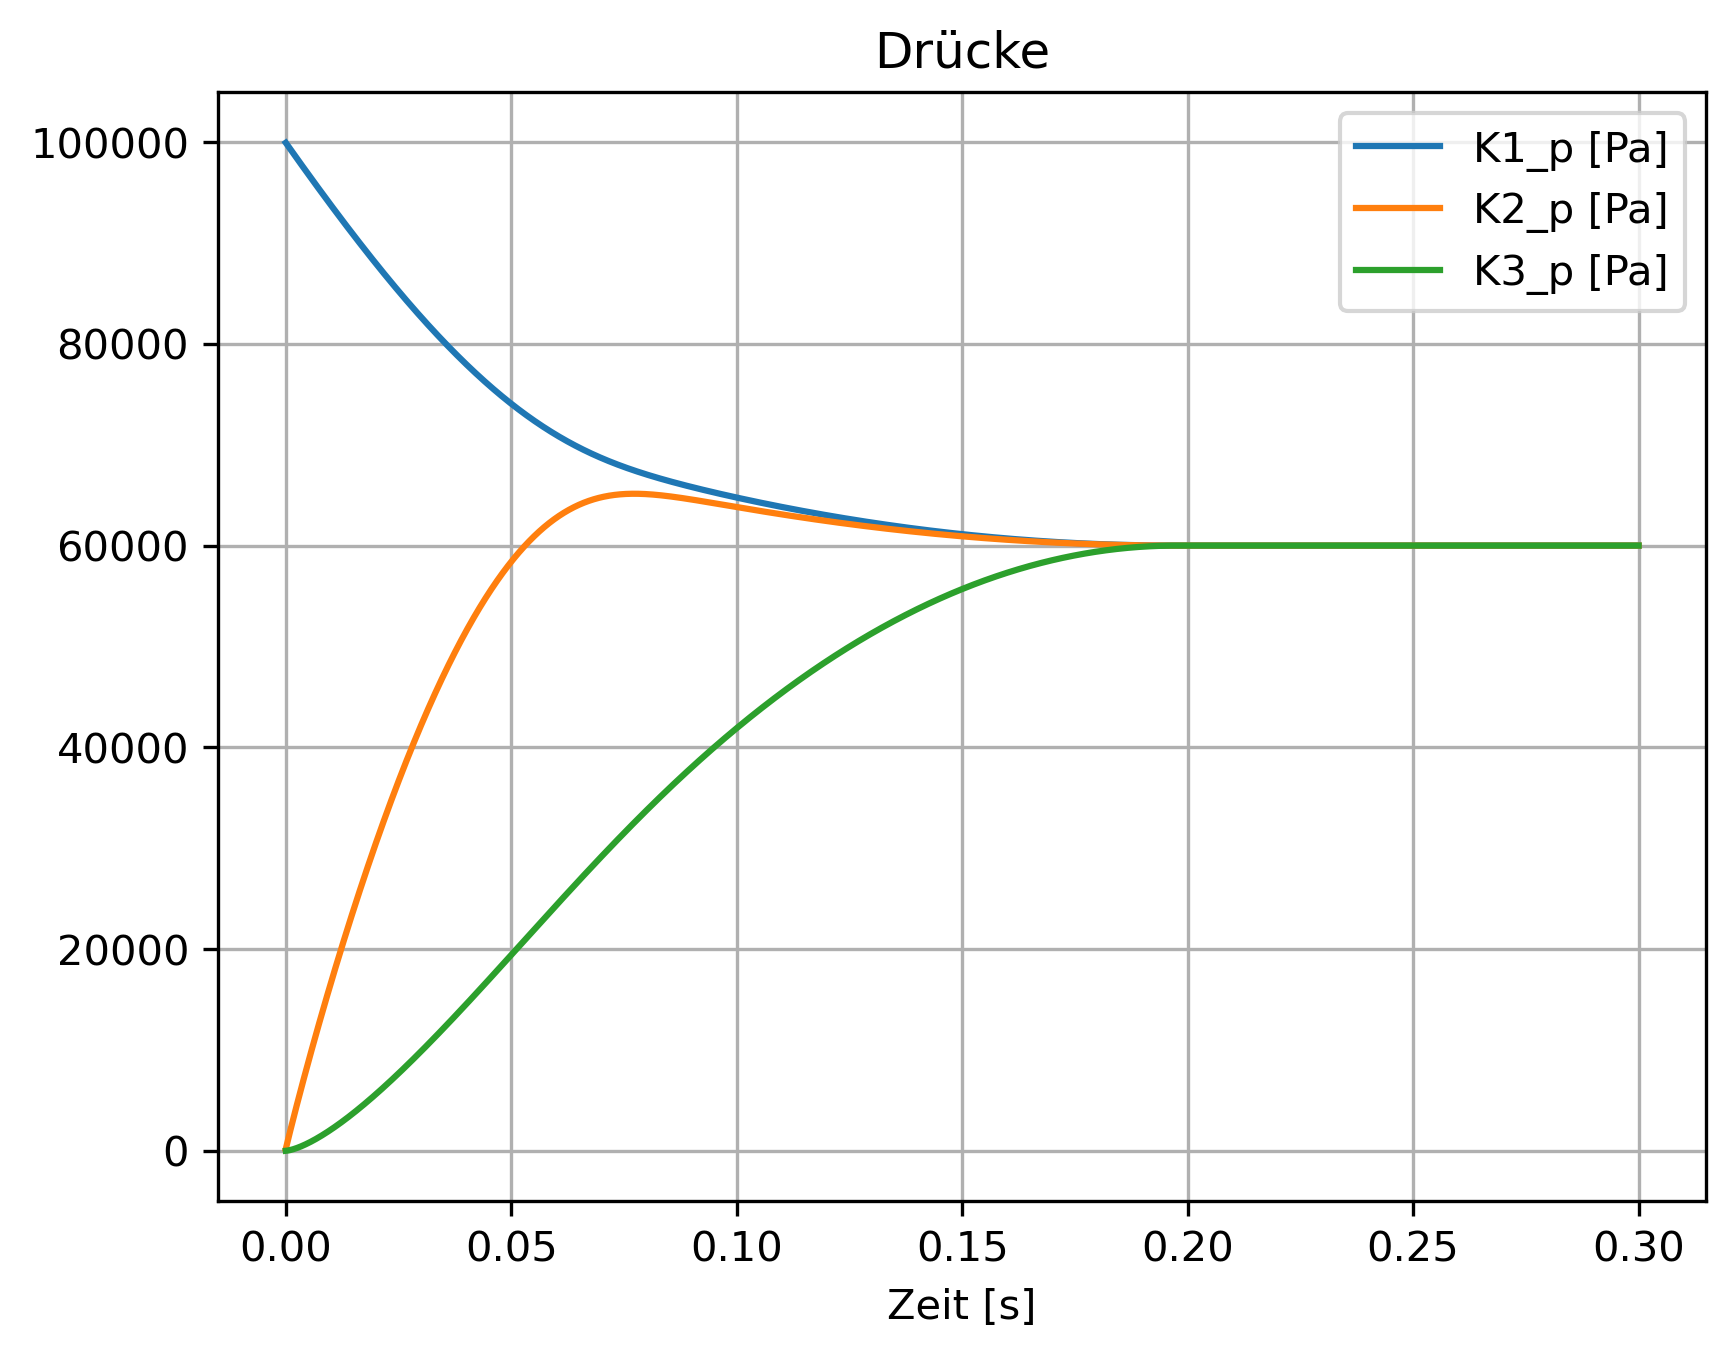

In [2]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Drücke')
plt.plot(datenlogger_t,datenlogger_K1.p,label='K1_p [Pa]')
plt.plot(datenlogger_t,datenlogger_K2.p,label='K2_p [Pa]')
plt.plot(datenlogger_t,datenlogger_K3.p,label='K3_p [Pa]')
#plt.xlim(0,20)
plt.xlabel('Zeit [s]')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/p.png')

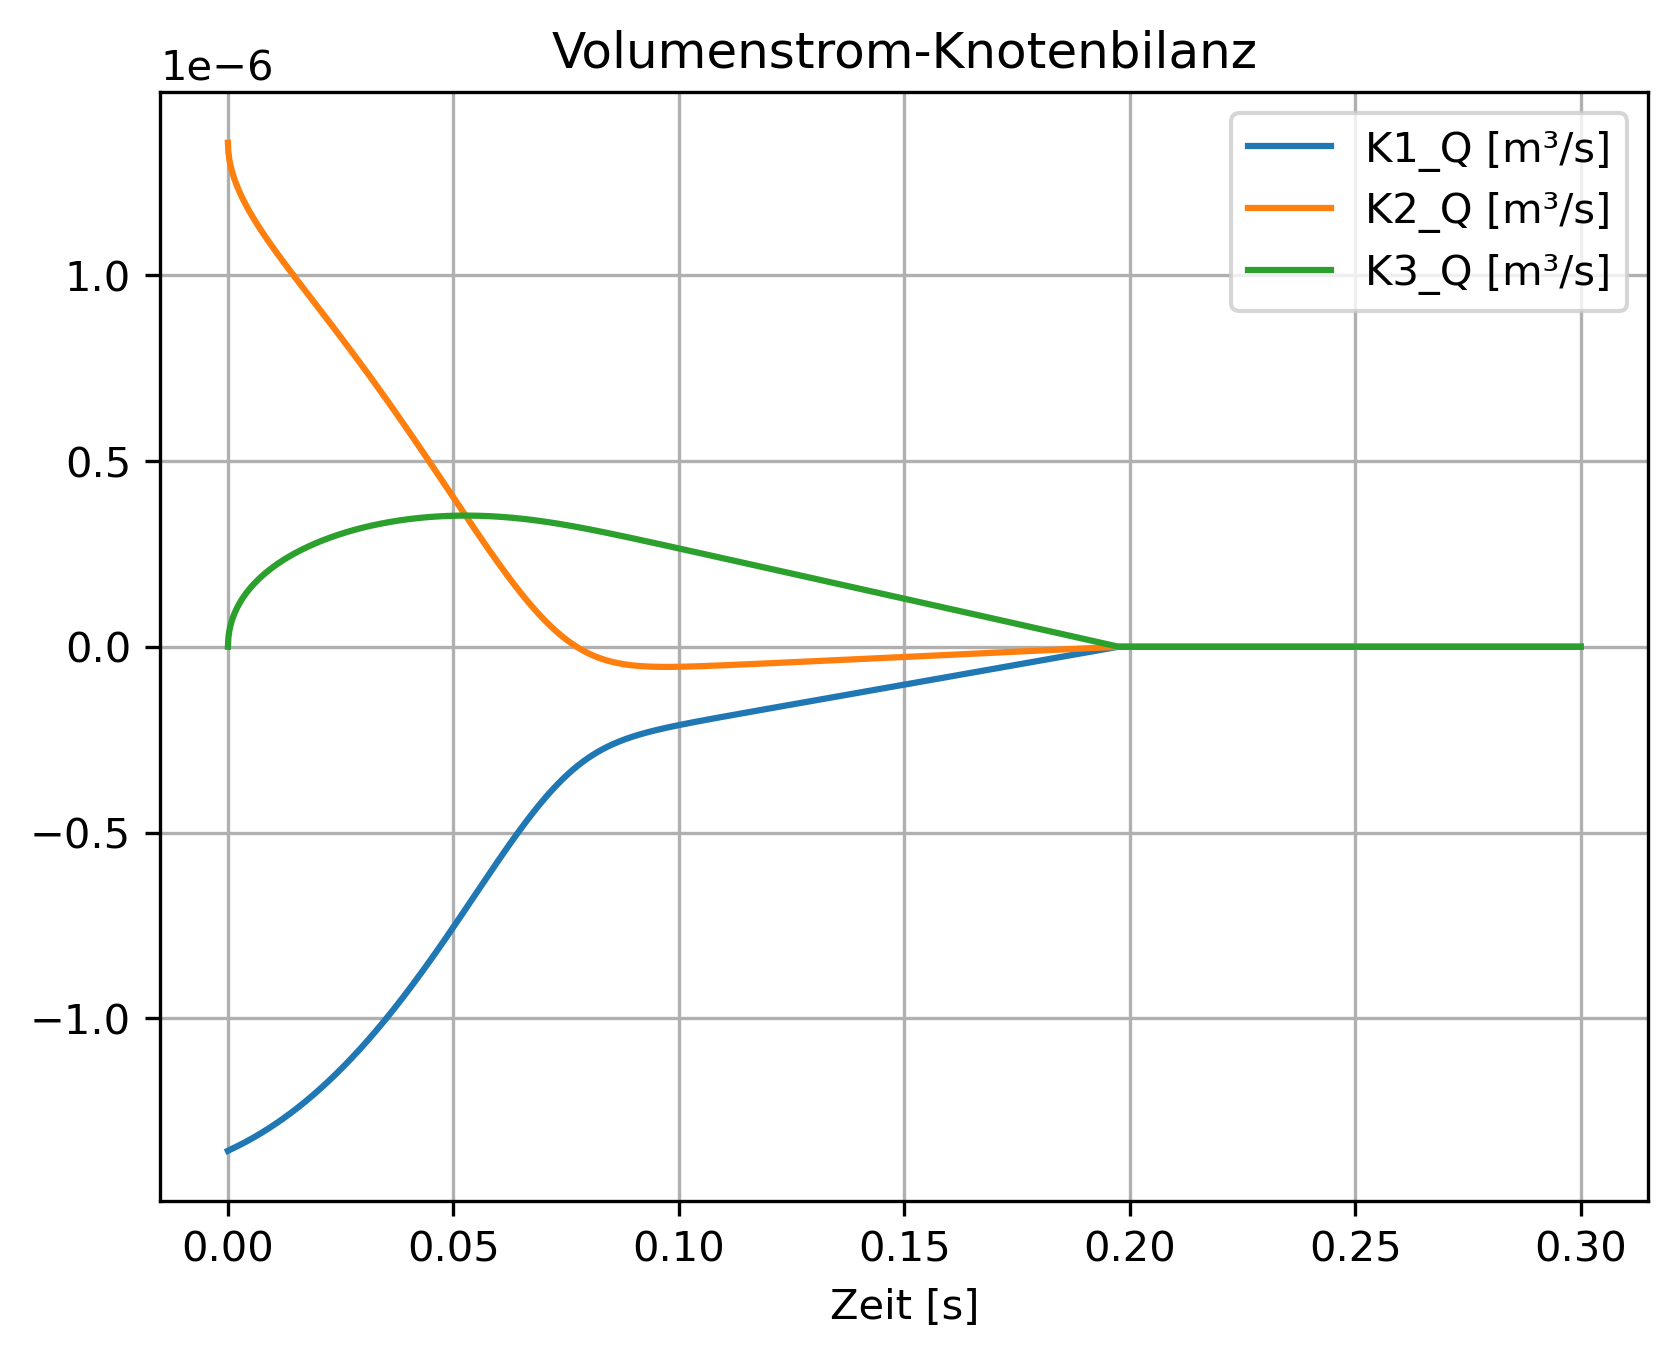

In [3]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Volumenstrom-Knotenbilanz')
plt.plot(datenlogger_t,datenlogger_K1.Q,label='K1_Q [m³/s]')
plt.plot(datenlogger_t,datenlogger_K2.Q,label='K2_Q [m³/s]')
plt.plot(datenlogger_t,datenlogger_K3.Q,label='K3_Q [m³/s]')
#plt.xlim(0,20)
plt.xlabel('Zeit [s]')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/q_sum.png')

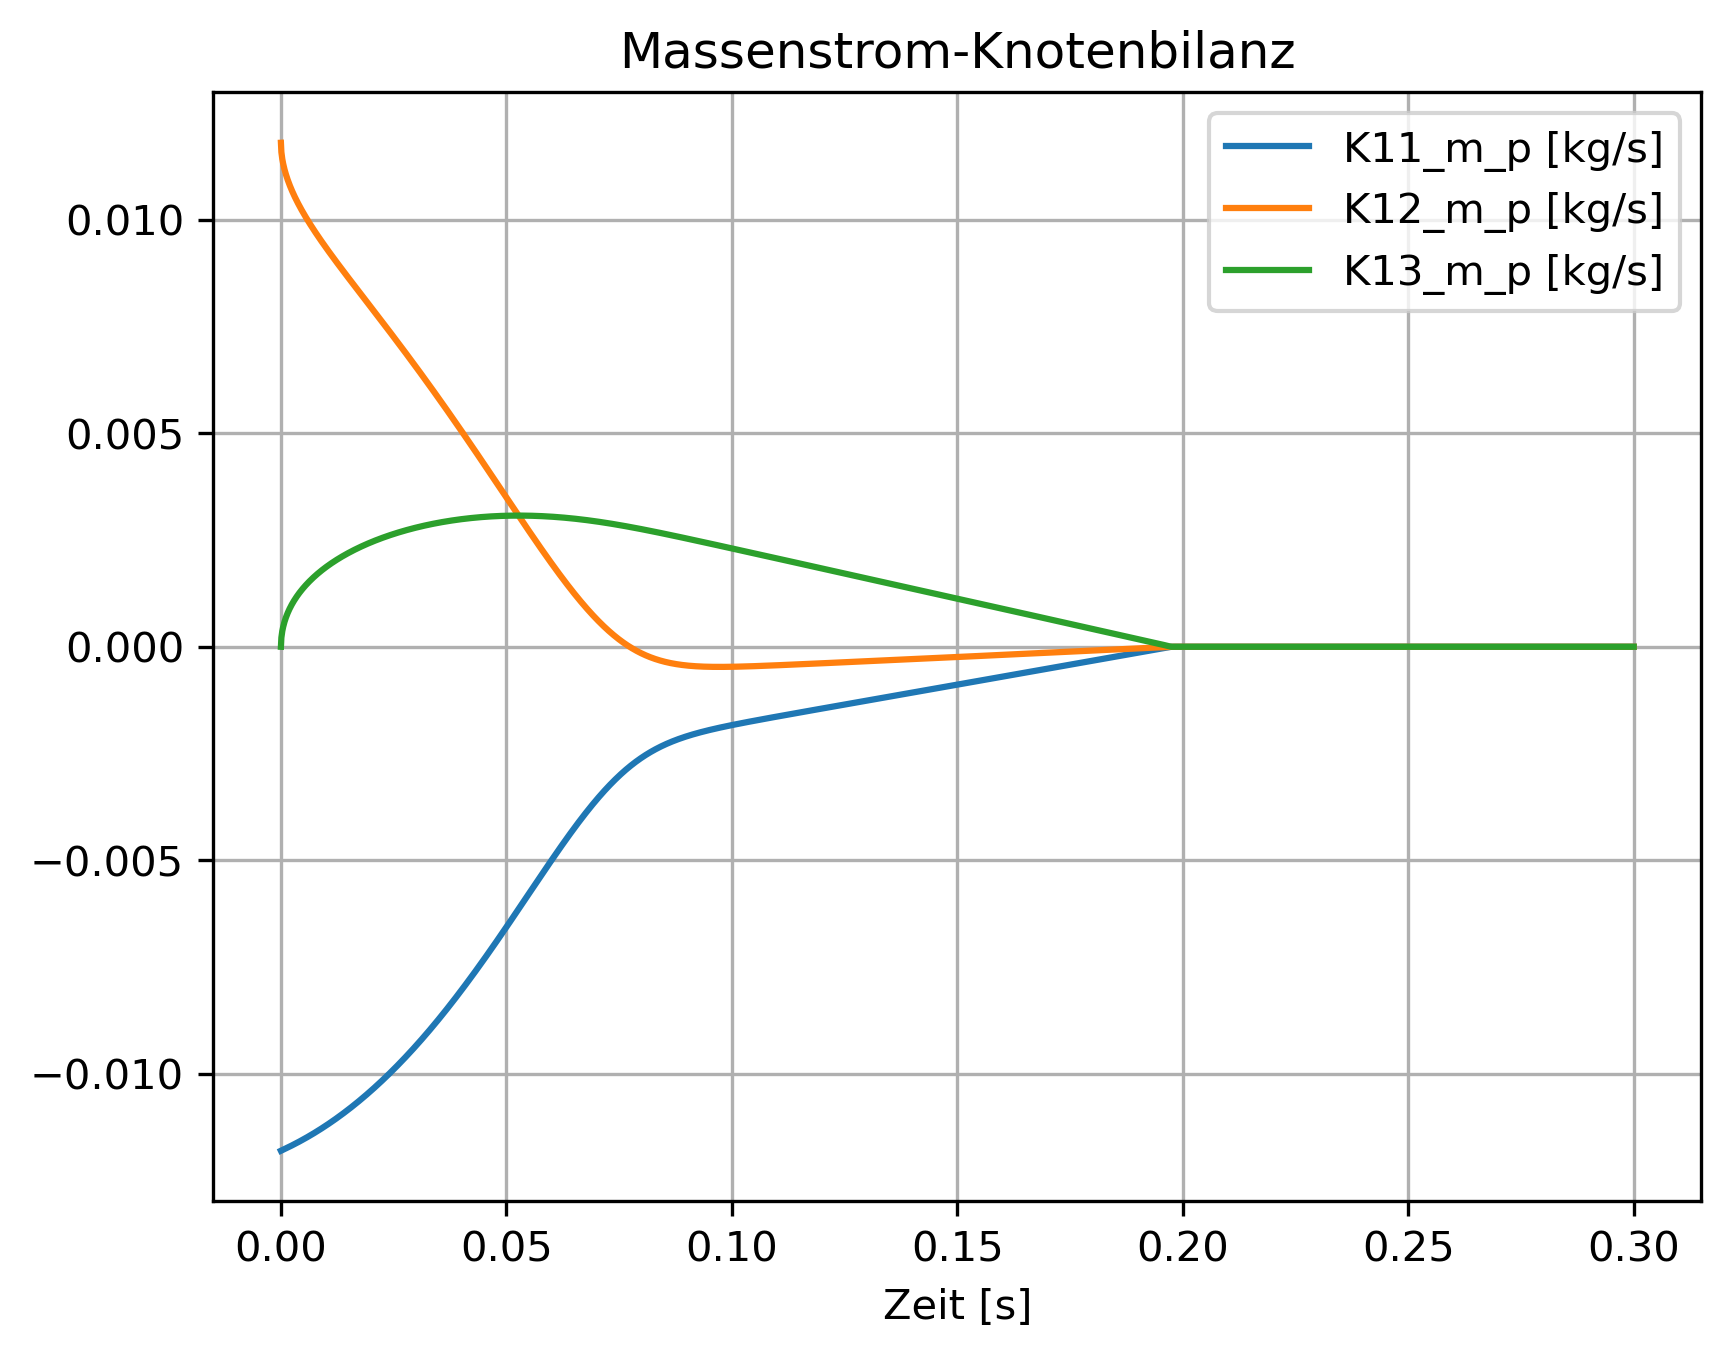

In [4]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Massenstrom-Knotenbilanz')
plt.plot(datenlogger_t,datenlogger_K11.m_p,label='K11_m_p [kg/s]')
plt.plot(datenlogger_t,datenlogger_K12.m_p,label='K12_m_p [kg/s]')
plt.plot(datenlogger_t,datenlogger_K13.m_p,label='K13_m_p [kg/s]')
#plt.xlim(0,20)
plt.xlabel('Zeit [s]')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/m_p_sum.png')

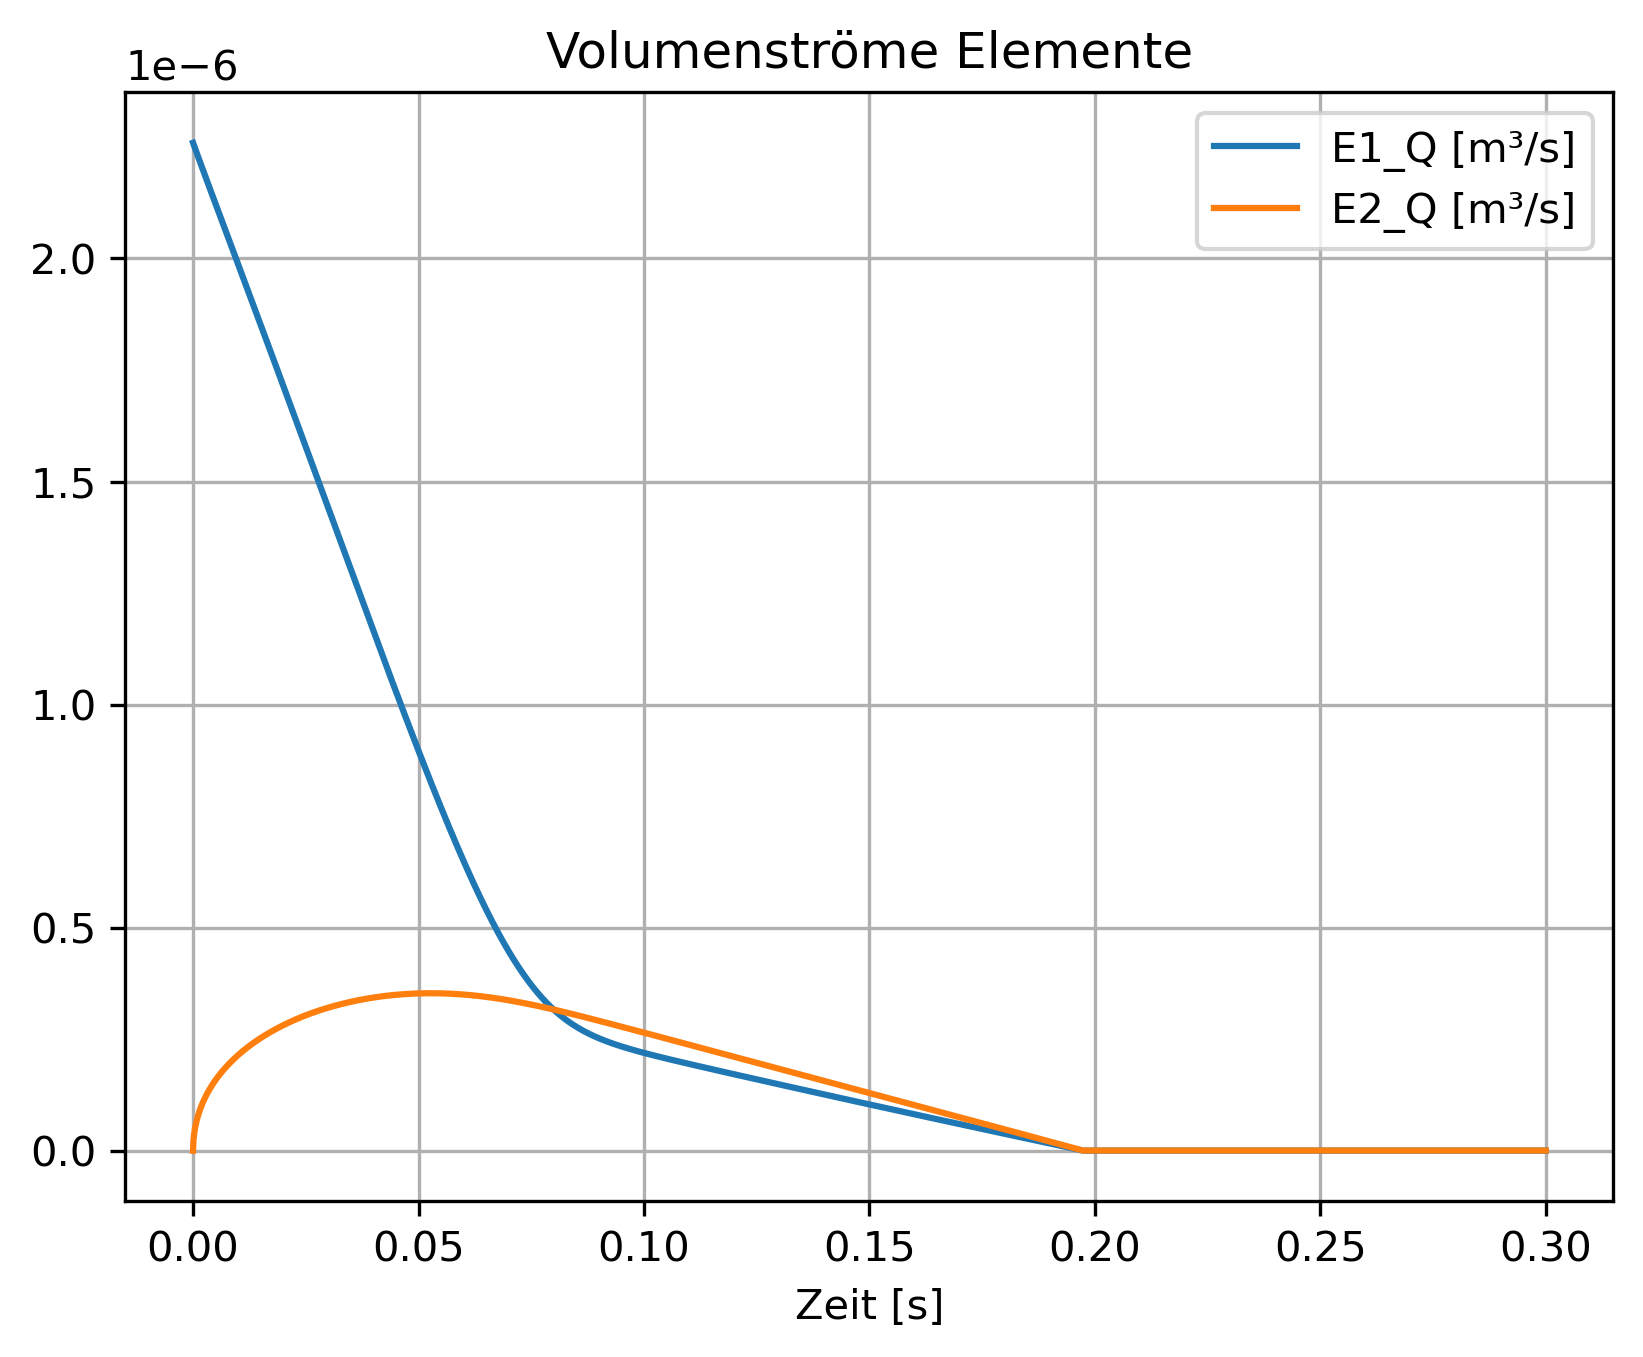

In [5]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Volumenströme Elemente')
plt.plot(datenlogger_t,datenlogger_E1.Q,label='E1_Q [m³/s]')
plt.plot(datenlogger_t,datenlogger_E2.Q,label='E2_Q [m³/s]')
#plt.xlim(0,20)
plt.xlabel('Zeit [s]')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/q.png')

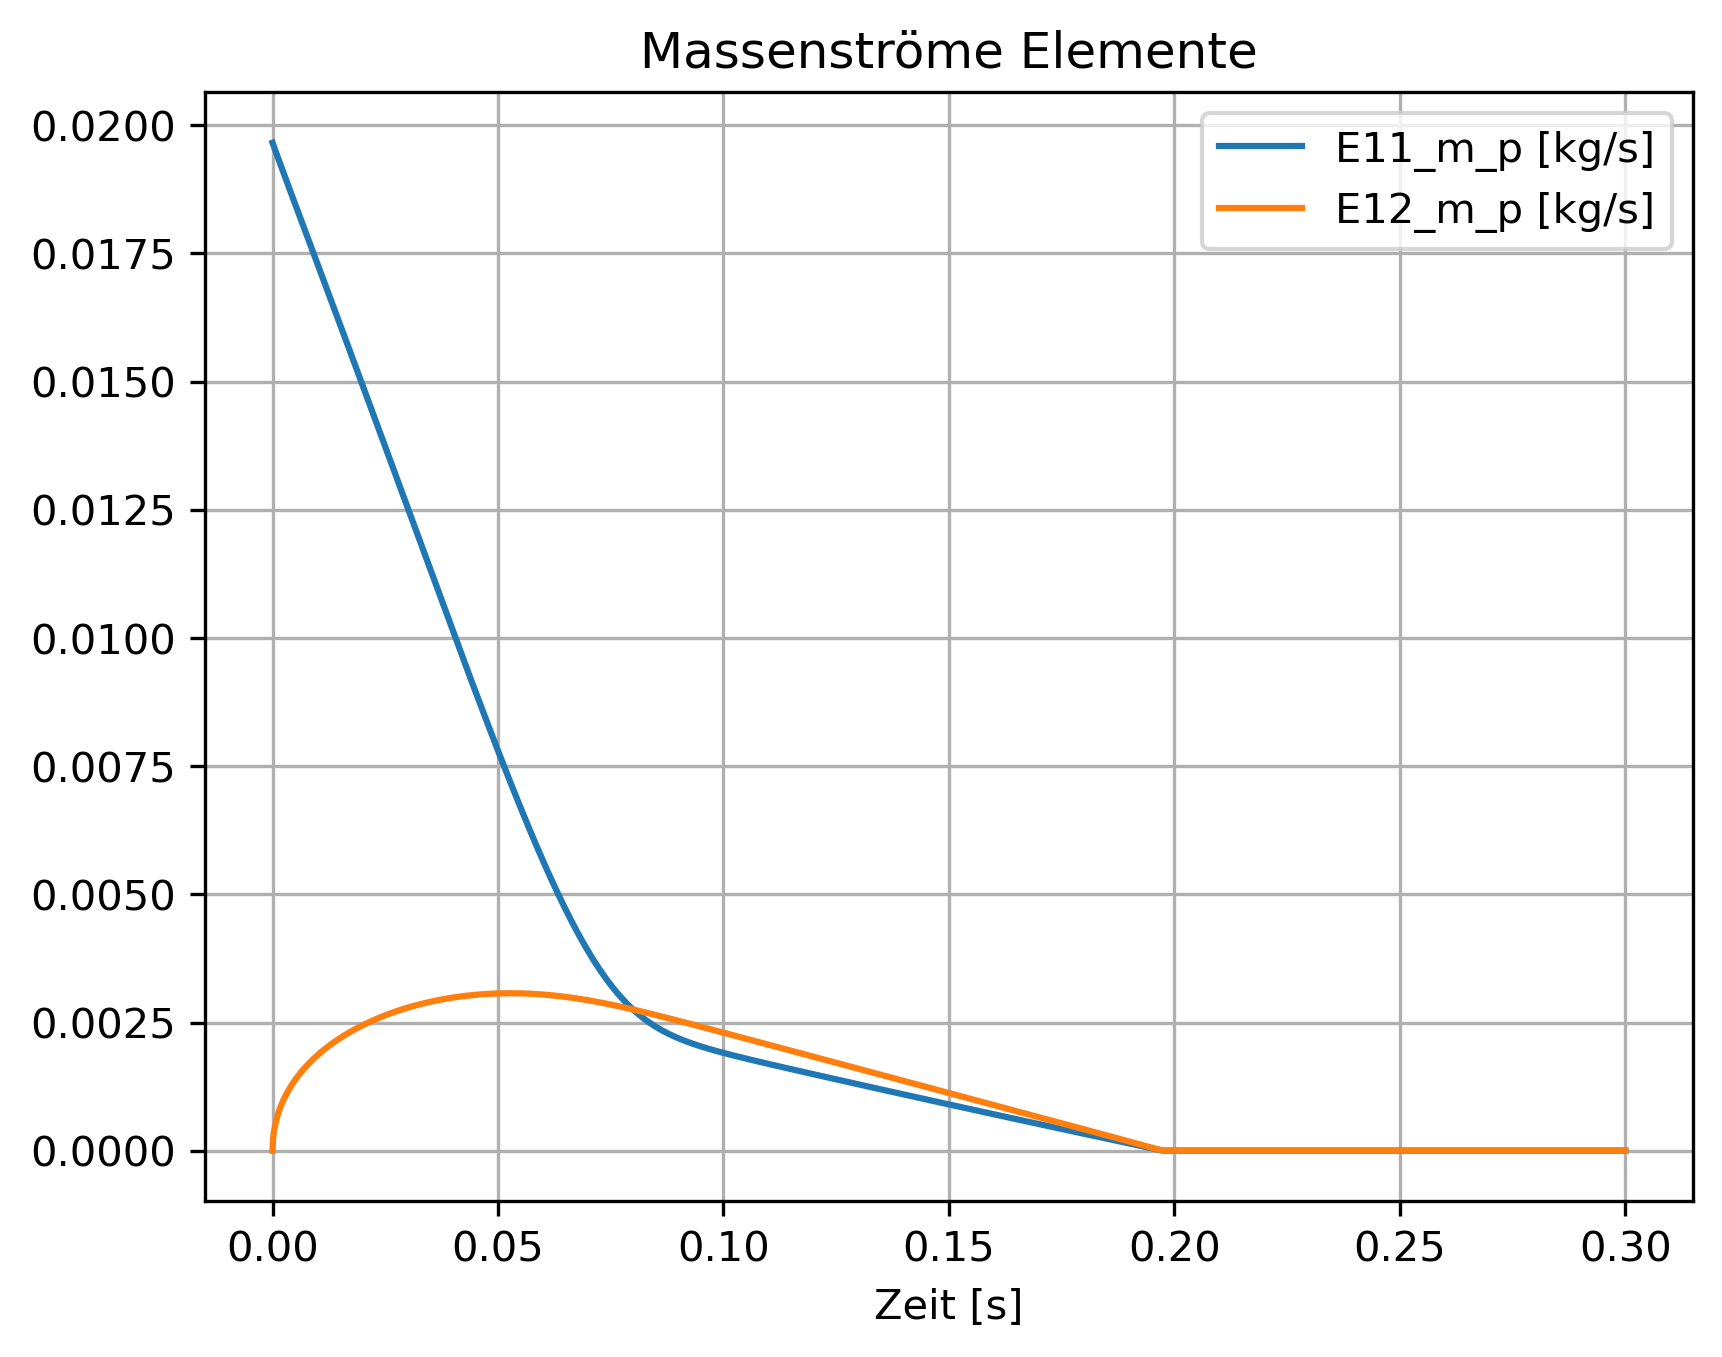

In [6]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title('Massenströme Elemente')
plt.plot(datenlogger_t,datenlogger_E11.m_p,label='E11_m_p [kg/s]')
plt.plot(datenlogger_t,datenlogger_E12.m_p,label='E12_m_p [kg/s]')
#plt.xlim(0,20)
plt.xlabel('Zeit [s]')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/m_p.png')

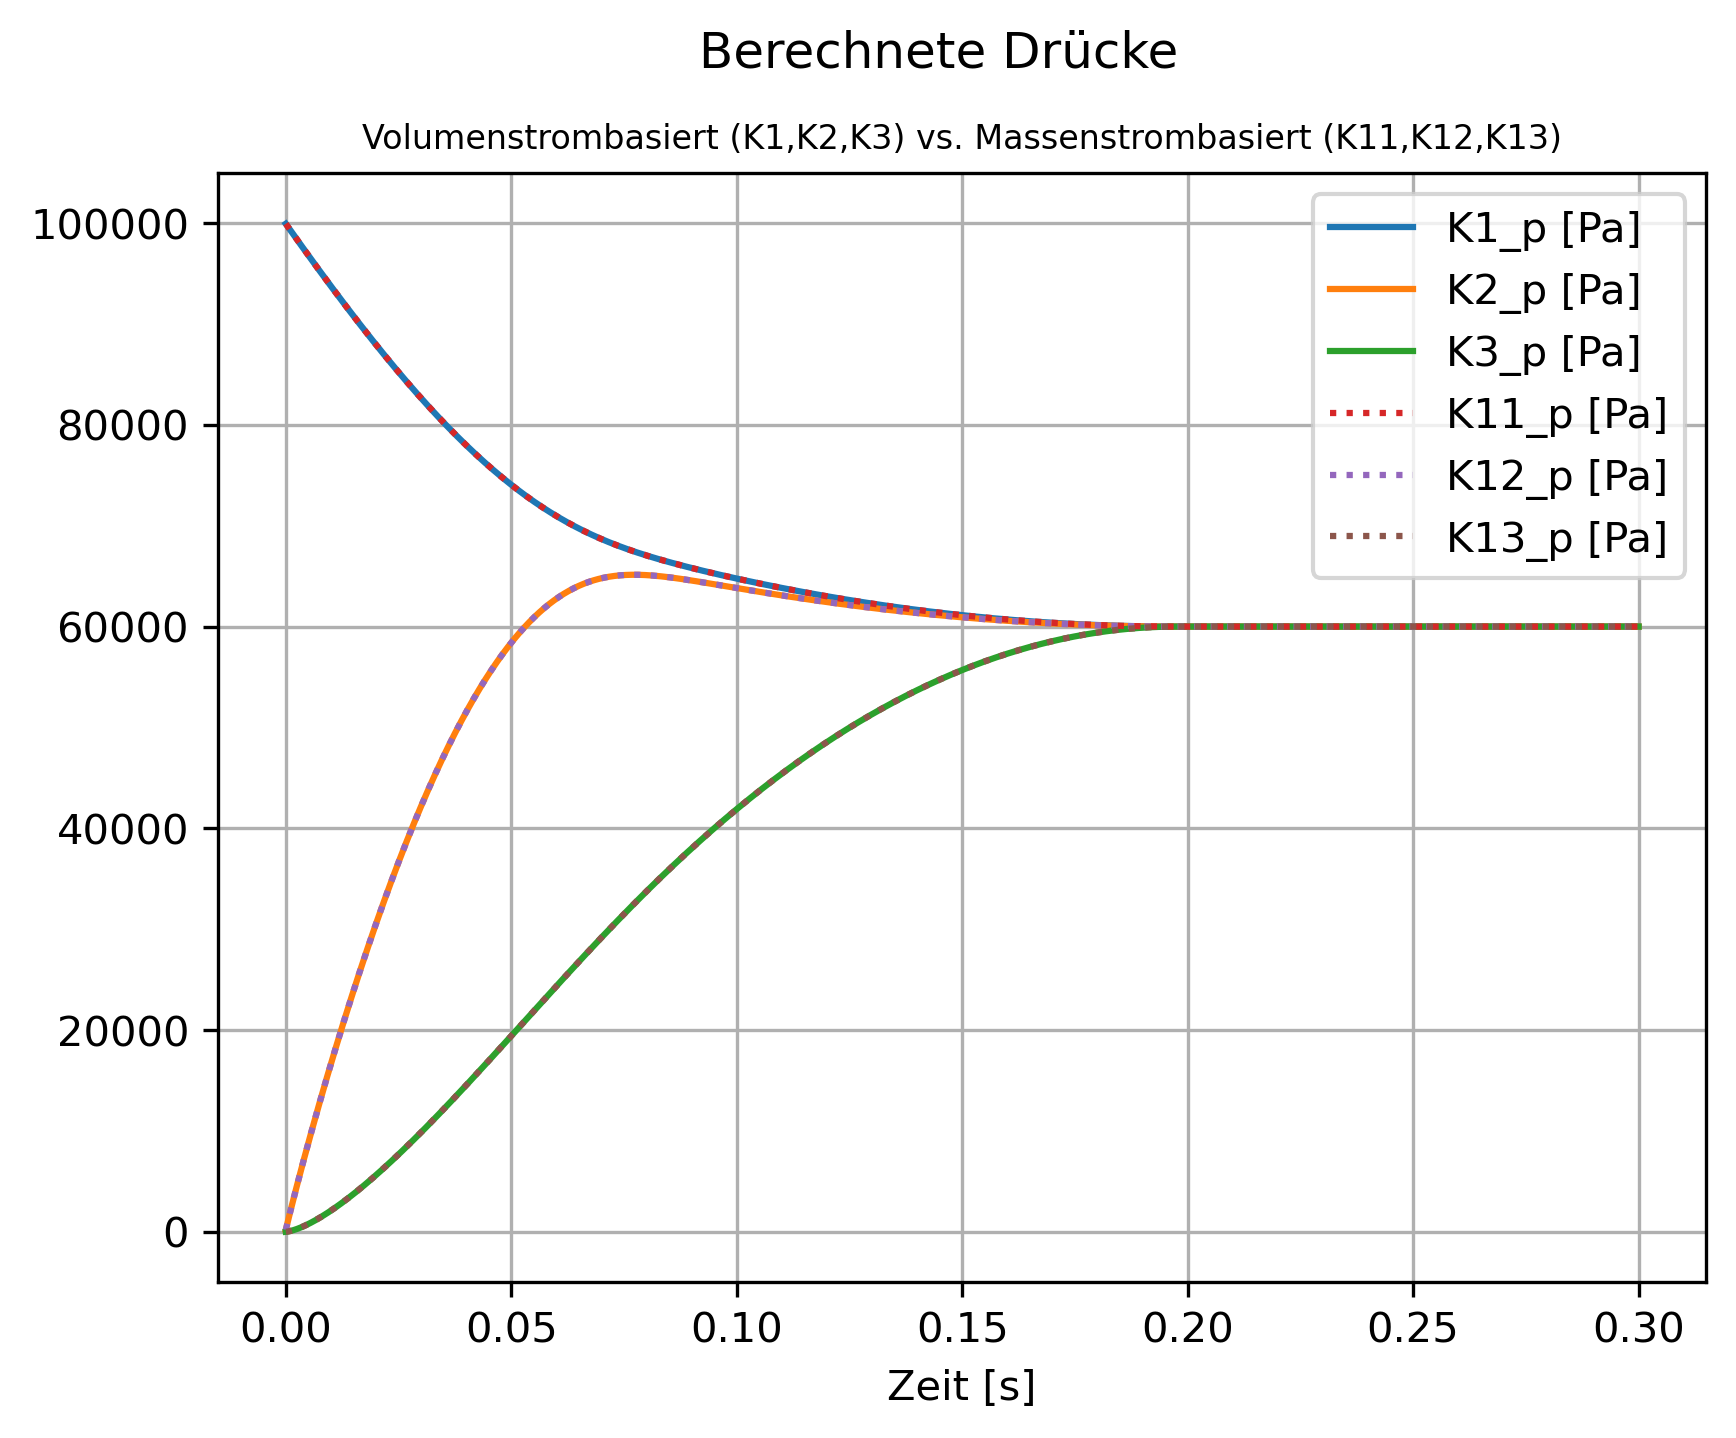

In [7]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.suptitle('Berechnete Drücke')
plt.title('Volumenstrombasiert (K1,K2,K3) vs. Massenstrombasiert (K11,K12,K13)',  fontsize=8)
plt.plot(datenlogger_t,datenlogger_K1.p,label='K1_p [Pa]')
plt.plot(datenlogger_t,datenlogger_K2.p,label='K2_p [Pa]')
plt.plot(datenlogger_t,datenlogger_K3.p,label='K3_p [Pa]')
plt.plot(datenlogger_t,datenlogger_K11.p,label='K11_p [Pa]',linestyle='dotted')
plt.plot(datenlogger_t,datenlogger_K12.p,label='K12_p [Pa]',linestyle='dotted')
plt.plot(datenlogger_t,datenlogger_K13.p,label='K13_p [Pa]',linestyle='dotted')
#plt.xlim(0,20)
plt.xlabel('Zeit [s]')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/vergleich_ansatz.png')

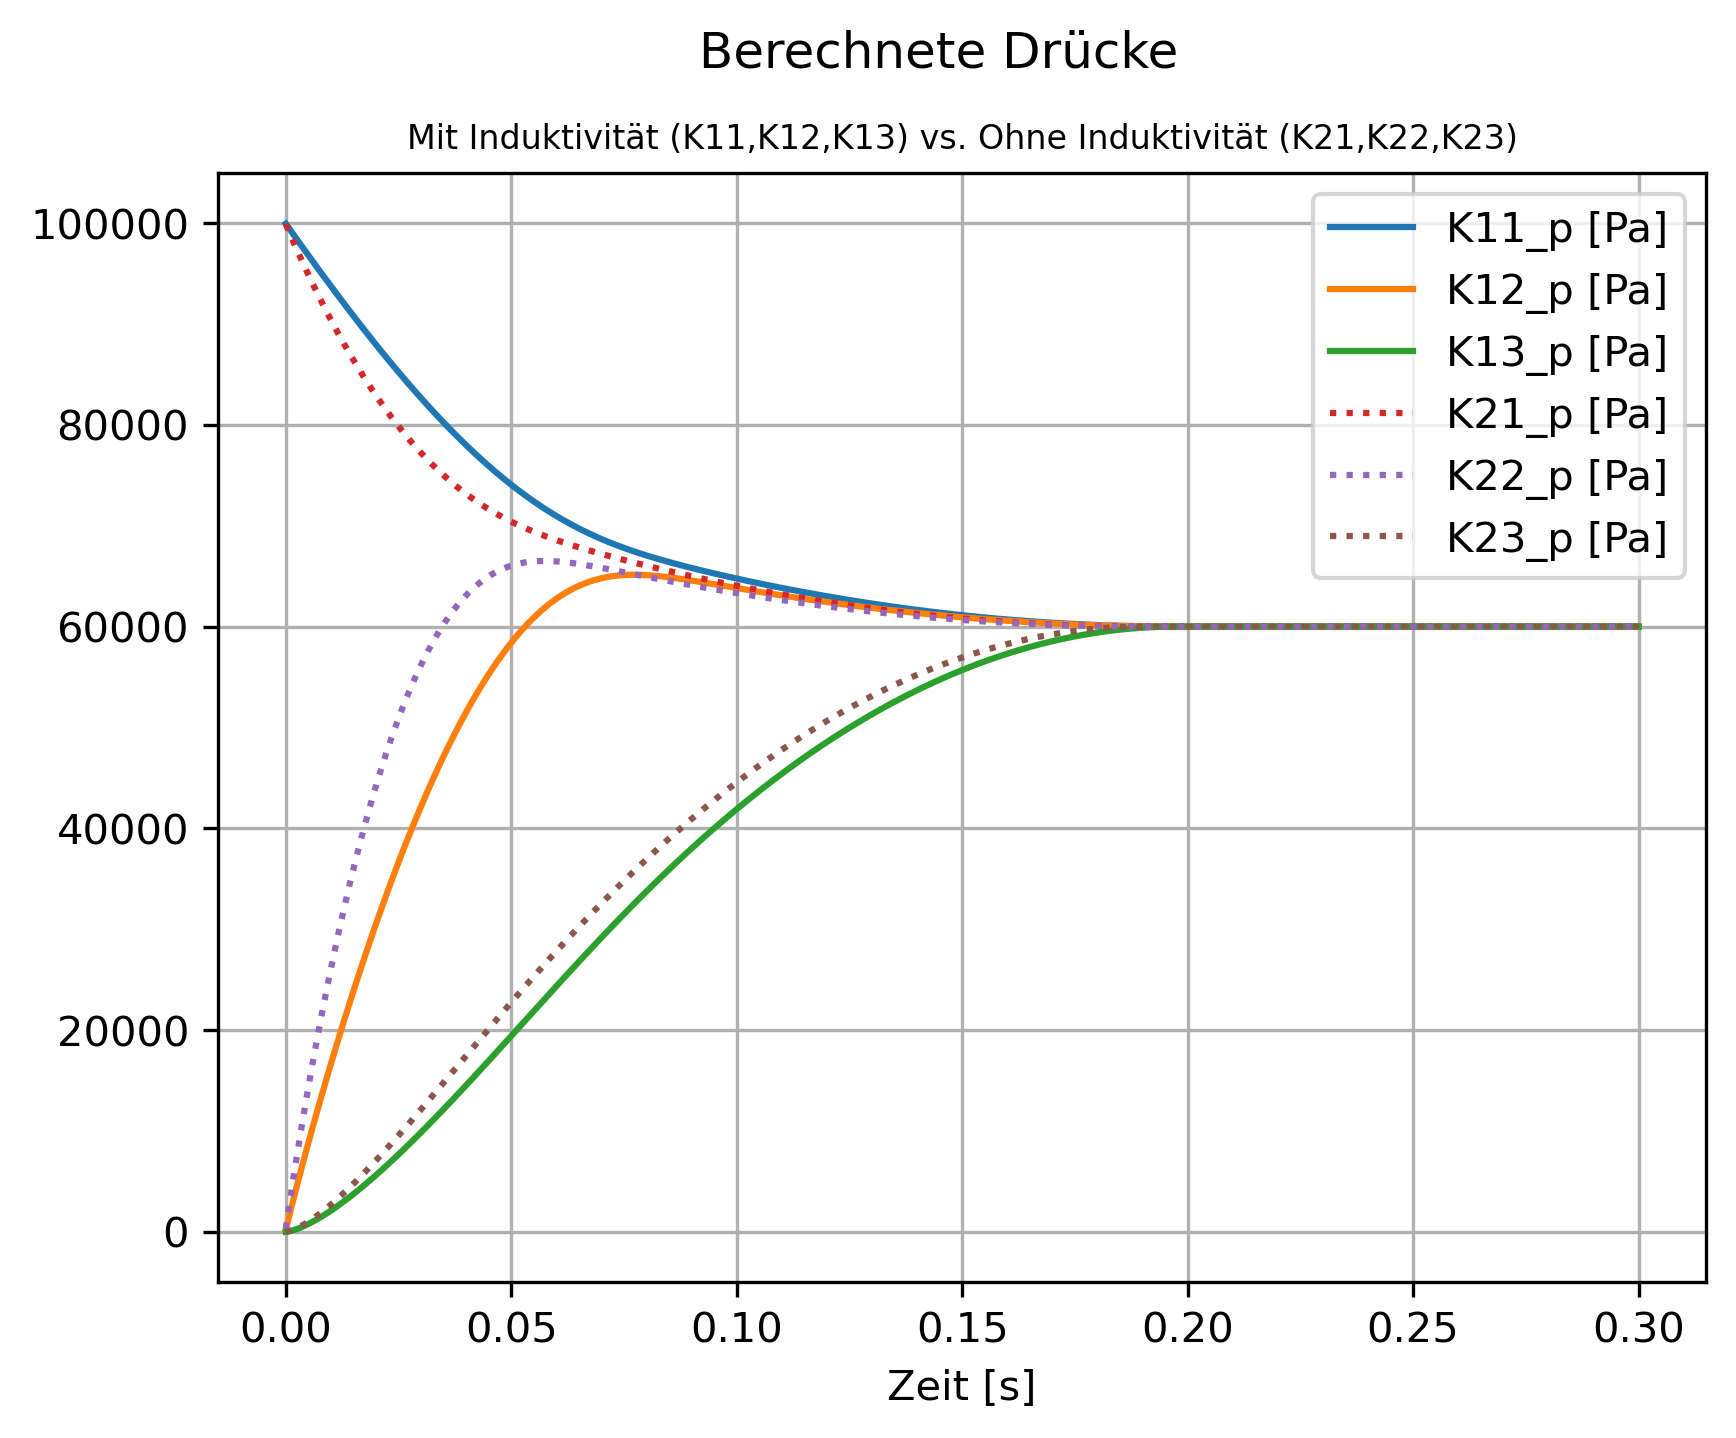

In [8]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.suptitle('Berechnete Drücke')
plt.title('Mit Induktivität (K11,K12,K13) vs. Ohne Induktivität (K21,K22,K23)',  fontsize=8)
plt.plot(datenlogger_t,datenlogger_K11.p,label='K11_p [Pa]')
plt.plot(datenlogger_t,datenlogger_K12.p,label='K12_p [Pa]')
plt.plot(datenlogger_t,datenlogger_K13.p,label='K13_p [Pa]')
plt.plot(datenlogger_t,datenlogger_K21.p,label='K21_p [Pa]',linestyle='dotted')
plt.plot(datenlogger_t,datenlogger_K22.p,label='K22_p [Pa]',linestyle='dotted')
plt.plot(datenlogger_t,datenlogger_K23.p,label='K23_p [Pa]',linestyle='dotted')
#plt.xlim(0,20)
plt.xlabel('Zeit [s]')
plt.grid(True)
plt.legend()
if (Bilder_speichern == True):
    plt.savefig('../output_bilder/vergleich_induktivitaet.png')